### Install `wfdb` Library

This code installs the `wfdb` Python library, which is used for reading, writing, and processing physiological signal data (such as ECG or other bio-signals). 

- The `!pip install -q wfdb` command is used to install the `wfdb` library via pip in a Jupyter notebook or similar environment.
- The `-q` flag stands for "quiet" mode, which suppresses most of the installation output for a cleaner experience.
  
By running this cell, the `wfdb` library will be available for use in subsequent code cells.


In [1]:
!pip install -q wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 3.8 MB/s eta 0:00:00


In [2]:
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import resample
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
# /kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/RECORDS -> Record path

### Import Libraries and Load ECG Data

This code imports several libraries and loads an ECG record from the MIT-BIH Arrhythmia Database:

1. **Load ECG Record**:
   - `record_name`: Specifies the path to the ECG record. In this case, it's set to the 101st record from the MIT-BIH Arrhythmia Database. 
   - `wfdb.rdrecord(record_name, channels=[0])`: Reads the ECG data from the specified record and loads only the first lead (`channels=[0]`).
   
2. **Load Annotations**:
   - `wfdb.rdann(record_name, 'atr')`: Loads the annotation file for the given record. The `'atr'` annotation file contains beat labels (e.g., normal beats, PVCs) for arrhythmia detection.

This setup prepares the data for further processing, such as signal analysis or visualization.


In [4]:
# Load the ECG record and annotation
record_name = "/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/101"  # Change this based on your dataset
record = wfdb.rdrecord(record_name, channels=[0])  # Load lead 0
annotation = wfdb.rdann(record_name, 'atr')


### Extract Signal and Sampling Frequency

In this code, the ECG signal and related information are extracted and prepared for further processing:

1. **Extract Signal and Sampling Frequency**:
   - `signal = record.p_signal.flatten()`: Extracts the ECG signal from the `record` object and flattens it from a 2D array to a 1D array for easier manipulation.
   - `fs = record.fs`: Retrieves the original sampling frequency (usually 360 Hz) from the record. This indicates how many samples are recorded per second.
   - `target_fs = 125`: Defines the target sampling frequency to which the signal might be resampled later. This value could be used to downsample the signal to 125 Hz.

2. **Get R-Peak Locations and Annotations**:
   - `r_peaks = annotation.sample`: Extracts the index positions of the R-peaks in the ECG signal, which are critical for detecting heartbeats and other arrhythmias.
   - `labels = annotation.symbol`: Retrieves the corresponding beat labels (e.g., normal beats, PVCs) for each R-peak. These annotations are important for classifying different types of heartbeats.

With these extracted components, the signal is now ready for analysis, and the annotations can be used for heart rhythm classification or further processing.


In [5]:
# Extract signal and sampling frequency
signal = record.p_signal.flatten()  # Convert 2D signal to 1D
fs = record.fs  # Original sampling rate (usually 360 Hz)
target_fs = 125  # Target sampling rate

# Get R-peak locations and annotations
r_peaks = annotation.sample  # Index positions of detected R-peaks
labels = annotation.symbol   # Corresponding beat labels

In [6]:
print(len(signal))
print(signal)

650000
[-0.345 -0.345 -0.345 ... -0.295 -0.29   0.   ]


## Checking the length of the R_peaks and labels Is equal or not

In [7]:
def check_len(r_peaks, labels):

    print(f"The length of the {len(r_peaks)}")
    print(f"The length of the {len(labels)}")
    if len(r_peaks) == len(labels):
        print("The length of the detected beats is equal to the length of the define labels")
    else:
        print("length is not match")
        

In [8]:
check_len(r_peaks, labels)

The length of the 1874
The length of the 1874
The length of the detected beats is equal to the length of the define labels


In [9]:
# sanity check

# window_size = int(0.6 * 360)
# print(window_size)
# print(window_size//2)
# print(77 + 108)

### Extract and Resample ECG Beats

This code processes the ECG signal to extract individual heartbeats and resample them to a target frequency (125 Hz):

1. **Initialization**:
   - `beat_labels = []`: A list to store the labels corresponding to each beat.
   - `beats = []`: A list to store the original ECG segments corresponding to each beat.
   - `resampled_beats = []`: A list to store the resampled ECG segments.
   - `window_size = int(0.6 * fs)`: Defines the size of the window (in samples) around each R-peak to extract the beat. A 0.6-second window is chosen based on the original sampling rate `fs` (usually 360 Hz).

2. **Loop to Extract Beats**:
   - The loop iterates over the detected R-peaks, excluding the first and last beats to avoid edge effects.
   - For each R-peak:
     - `start = max(0, r_peaks[i] - window_size // 2)`: Sets the start of the window, ensuring it doesn't go below 0.
     - `end = min(len(signal), r_peaks[i] + window_size // 2)`: Sets the end of the window, ensuring it doesn't exceed the signal length.
     - `beat = signal[start:end]`: Extracts the ECG segment corresponding to the current heartbeat.

3. **Resampling**:
   - `num_samples = int(len(beat) * (target_fs / fs))`: Calculates the number of samples required to resample the beat to the target frequency (`target_fs = 125 Hz`).
   - `resampled_beat = resample(beat, num_samples)`: Resamples the extracted beat to the target sampling frequency.

4. **Store Results**:
   - `beats.append(beat)`: Adds the original beat segment to the `beats` list.
   - `resampled_beats.append(resampled_beat)`: Adds the resampled beat segment to the `resampled_beats` list.
   - `beat_labels.append(labels[i])`: Adds the label corresponding to the current beat to the `beat_labels` list.

This process prepares the ECG beats for further analysis, such as classification or feature extraction, with the beats now resampled to a consistent frequency.


In [10]:
beat_labels = []
beats = []
resampled_beats = []
window_size = int(0.6 * fs)  # 0.6s window around R-peak (adjust if needed)

for i in range(1, len(r_peaks) - 1):  # Ignore first & last beats
    start = max(0, r_peaks[i] - window_size // 2)
    end = min(len(signal), r_peaks[i] + window_size // 2)
    beat = signal[start:end]  # Extract the beat segment
    
    # Resample to 125 Hz
    num_samples = int(len(beat) * (target_fs / fs))
    # print(num_samples)
    resampled_beat = resample(beat, num_samples)

    beats.append(beat)
    resampled_beats.append(resampled_beat)
    beat_labels.append(labels[i])


### Plotting the signal beat

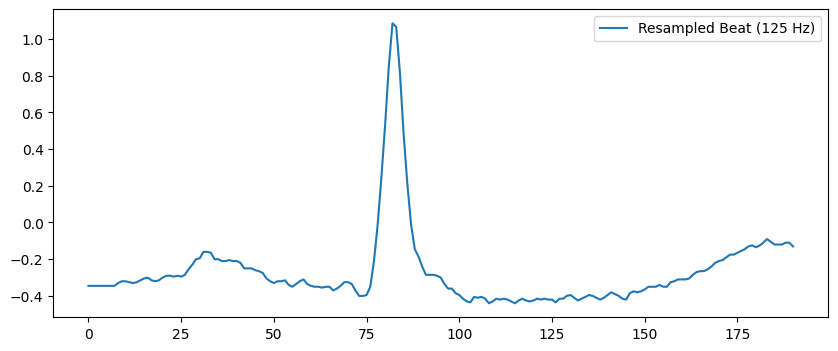

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(beats[0], label=f"Resampled Beat (125 Hz)")
plt.legend()
plt.show()

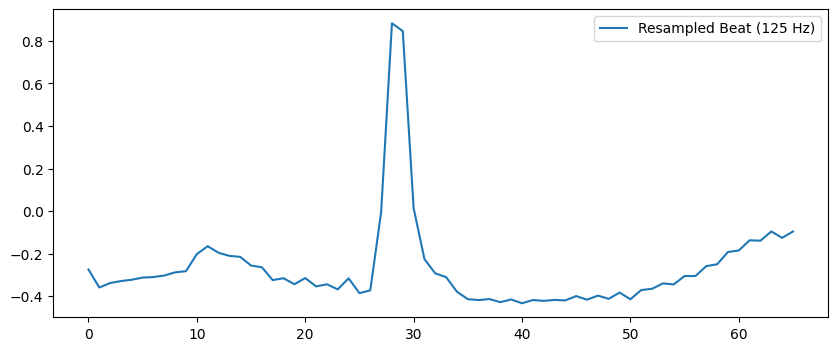

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(resampled_beats[0], label=f"Resampled Beat (125 Hz)")
plt.legend()
plt.show()

#### Final verdict is that the csv file will contains the multiple columns that will represent the features for the beat

### Interpolate ECG Beat to a Target Length

This function performs linear interpolation to resize an ECG beat segment to a target length, preserving the shape of the signal.

#### Function: `interpolate_beat(beat, target_length)`

1. **Parameters**:
   - `beat`: The ECG beat segment (a 1D array or list) that needs to be interpolated.
   - `target_length`: The desired length (number of samples) for the interpolated beat.

2. **Steps**:
   - `x_old = np.linspace(0, 1, len(beat))`: Creates the original time scale based on the number of samples in the input `beat`. This represents the positions of the samples in the original signal.
   - `x_new = np.linspace(0, 1, target_length)`: Creates a new time scale for the target length (i.e., the desired number of samples after interpolation).
   - `f = interp1d(x_old, beat, kind='linear')`: Defines a linear interpolation function using the `interp1d` method from the `scipy.interpolate` module. This function will map the original time scale (`x_old`) to the `beat` values.
   - `return f(x_new)`: Returns the interpolated ECG beat at the new time scale (`x_new`), resizing it to the `target_length`.

#### Purpose:
This function is useful when you need to standardize the length of ECG beats, especially when resampling or aligning beats to a consistent number of samples, ensuring that each beat has the same duration in time for further analysis or classification.


In [13]:
def interpolate_beat(beat, target_length):
    x_old = np.linspace(0, 1, len(beat))  # Original time scale
    x_new = np.linspace(0, 1, target_length)  # Target time scale
    f = interp1d(x_old, beat, kind='linear')  # Linear interpolation
    return f(x_new)

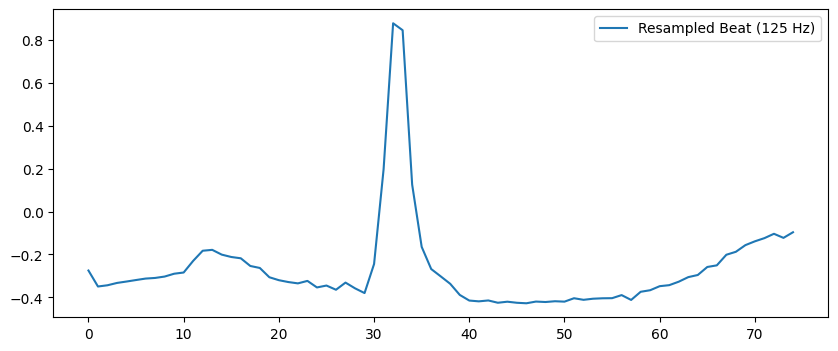

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(interpolate_beat(resampled_beats[0], 75), label=f"Resampled Beat (125 Hz)")
plt.legend()
plt.show()

### Checking the Distinct length of beat

In [15]:
count_65 = 0
count_75 = 0
beat_set = list()

for beat in resampled_beats:
    if len(beat) == 64:
        count_65 = count_65 + 1
    else:
        count_75 += 1
    beat_set.append(len(beat))

beat_set = set(beat_set)
print(beat_set)

{66, 75}


In [16]:
print(f"The beat with 65 length {count_65}")
print(f"The beat with 75 length {count_75}")

The beat with 65 length 0
The beat with 75 length 1872


In [17]:
same_size_resample_beat = []
new_labels = []

for beat, label in zip(resampled_beats, beat_labels):
    if len(beat) == 75:
        same_size_resample_beat.append(beat)
        new_labels.append(label)
        

In [18]:
print(f"The all the beat with the same length {len(same_size_resample_beat)}")
print(f"The labels crossponding to the beat {len(new_labels)}")

The all the beat with the same length 1871
The labels crossponding to the beat 1871


### Converting the beat into DataFrame

In [19]:
resampled_beats = np.array(same_size_resample_beat)
labels = np.array(new_labels)

In [20]:
print(resampled_beats.shape)
print(labels.shape)

(1871, 75)
(1871,)


In [21]:
resampled_beats_with_labels = [np.append(resampled_beats[i], labels[i]) for i in range(len(resampled_beats))]
resampled_beats_with_labels = np.array(resampled_beats_with_labels, dtype=object)

print(resampled_beats_with_labels.shape)

(1871, 76)


In [22]:
data = pd.DataFrame(resampled_beats_with_labels)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,-0.2765826941799416,-0.3414947338554218,-0.3195020458148922,-0.3199608517066094,-0.32617286403445145,-0.32636660070586576,-0.3405209039758399,-0.3268892680826637,-0.336339477570425,-0.324916688252171,...,-0.24958390569979516,-0.24960007982693724,-0.2085145914767063,-0.21228575018738383,-0.15156509221728137,-0.14419822642018532,-0.10952199337172687,-0.13665063915734388,-0.09931202250191487,N
1,-0.21755352143525866,-0.29493327651162243,-0.2679278415782136,-0.2862619171262596,-0.2666114088242677,-0.2806054455084041,-0.2678279454601262,-0.2755352625381687,-0.2672948694326798,-0.275274643642554,...,-0.28899431909151985,-0.24566443594395923,-0.23632591941259737,-0.19445992234043163,-0.17183247492684803,-0.14693808670701208,-0.14003849388070508,-0.12808739763871296,-0.11985395431515838,N
2,-0.30805563210014464,-0.3507280287832321,-0.3764897986291018,-0.36666236040479155,-0.3618554634529202,-0.3491222310145302,-0.3687702642114315,-0.3592514652185586,-0.3623241468688399,-0.3654804359403824,...,-0.40165375512511253,-0.3820807931528156,-0.35736983068353784,-0.33406113969352724,-0.28363285575853475,-0.2692715147846346,-0.22755549097260247,-0.24065735618359255,-0.16728280320788788,N
3,-0.35084279791713957,-0.4282057450063681,-0.40902368105689485,-0.4122230033020528,-0.41021206183634096,-0.4024040495910697,-0.4245405390888037,-0.40315863997856033,-0.4242962949019887,-0.40777395648430365,...,-0.3698385642268374,-0.37083089848655265,-0.345511323030627,-0.32916681382076707,-0.2801198253618152,-0.2689900998818088,-0.22949536631208012,-0.24013339812524867,-0.17836758890710216,N
4,-0.3157656024003587,-0.32358595391176587,-0.31364174566560277,-0.3221809830810448,-0.31319111959120927,-0.32584559902974436,-0.31680874150095806,-0.3149316949313722,-0.32392717796346626,-0.31466110031192535,...,-0.4688703020706729,-0.4396827953584166,-0.4598090967473371,-0.41338031879452186,-0.41441560801224464,-0.36442509545421997,-0.36583450605585044,-0.3230337048096841,-0.32196406409259015,N


In [23]:
np.unique(data.iloc[:, -1])

array(['A', 'N', 'Q', '|', '~'], dtype=object)